In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ~/bmi_dynamics_code/

/Users/preeyakhanna/bmi_dynamics_code


In [3]:
import matplotlib.pyplot as plt
import ssm
from ssm.util import random_rotation

from online_analysis import generate_models, util_fcns

In [4]:
from sklearn.linear_model import Ridge


In [27]:
A1 = random_rotation(D_latent, np.pi/24.)
A2 = random_rotation(D_latent, np.pi/48.)

In [6]:
def make_nascar_model(A1, A2, D_latent, D_obs, K, nTrls = 20, T = 50, 
                      sigma_noise = 1e-4, em_noise = 1e-2):
    
    # Simulate the nascar data
    As = [A1, A2]

    # Set the center points for each system
    centers = [np.array([+2.0, 0.]),
          np.array([-2.0, 0.])]
    
#     centers = [np.array([+10.0, 0.]),
#            np.array([-10.0, 0.])]
    
    bs = [-(A - np.eye(D_latent)).dot(center) for A, center in zip(As, centers)]

    # Add a "right" state
    As.append(np.eye(D_latent))
    bs.append(np.array([+0.1, 0.]))

    # Add a "right" state
    As.append(np.eye(D_latent))
    bs.append(np.array([-0.25, 0.]))

    # Construct multinomial regression to divvy up the space
    w1, b1 = np.array([+1.0, 0.0]), np.array([-2.0])   # x + b > 0 -> x > -b
    w2, b2 = np.array([-1.0, 0.0]), np.array([-2.0])   # -x + b > 0 -> x < b
    w3, b3 = np.array([0.0, +1.0]), np.array([0.0])    # y > 0
    w4, b4 = np.array([0.0, -1.0]), np.array([0.0])    # y < 0
    Rs = np.row_stack((100*w1, 100*w2, 10*w3,10*w4))
    r = np.concatenate((100*b1, 100*b2, 10*b3, 10*b4))

    true_rslds = ssm.SLDS(D_obs, K, D_latent,
                      transitions="recurrent_only",
                      dynamics="diagonal_gaussian",
                      emissions="gaussian_orthog",
                      single_subspace=True)
    
    true_rslds.dynamics.mu_init = np.tile(np.array([[0, 1]]), (K, 1))
    true_rslds.dynamics.sigmasq_init = sigma_noise * np.ones((K, D_latent))
    true_rslds.dynamics.As = np.array(As)
    true_rslds.dynamics.bs = np.array(bs)
    true_rslds.dynamics.sigmasq = sigma_noise * np.ones((K, D_latent))

    true_rslds.transitions.Rs = Rs
    true_rslds.transitions.r = r

    true_rslds.emissions.inv_etas = np.log(em_noise) * np.ones((1, D_obs))
    
    ### Generate data ###
    # ## Generate data ###
    y1 = []; x2 = []; y2 = []; 
    for i in range(nTrls):
        _, _, y_ = true_rslds.sample(T=T)
        y1.append(y_)
        _, x_2, y_2 = true_rslds.sample(T=T)
        x2.append(x_2)
        y2.append(y_2)    
    
    return true_rslds, y1, x2, y2

In [40]:
def plot_most_likely_dynamics(model,
    xlim=(-20, 20), ylim=(-20, 20), nxpts=60, nypts=60,
    alpha=0.8, ax=None, figsize=(3, 3)):
    colors = ['r','b','g','yellow']

    K = model.K
    assert model.D == 2
    x = np.linspace(*xlim, nxpts)
    y = np.linspace(*ylim, nypts)
    X, Y = np.meshgrid(x, y)
    xy = np.column_stack((X.ravel(), Y.ravel()))

    # Get the probability of each state at each xy location
    log_Ps = model.transitions.log_transition_matrices(
        xy, np.zeros((nxpts * nypts, 0)), np.ones_like(xy, dtype=bool), None)
    z = np.argmax(log_Ps[:, 0, :], axis=-1)
    z = np.concatenate([[z[0]], z])

    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)

    for k, (A, b) in enumerate(zip(model.dynamics.As, model.dynamics.bs)):
        dxydt_m = xy.dot(A.T) + b - xy

        zk = z == k
        if zk.sum(0) > 0:
            ax.quiver(xy[zk, 0], xy[zk, 1],
                      dxydt_m[zk, 0], dxydt_m[zk, 1],
                      color=colors[k % len(colors)], alpha=alpha)

    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

    plt.tight_layout()

    return ax


In [8]:
def get_R2_fit_vs_true(fit_rslds, true_rslds, x2, y2): 
    
    ### Fit posterior with trained model; 
    window = 5; 
    post_est = []; 
    
    xhat2 = []; 
    pred_pt = []
    
    for trl in range(len(y2)): 
        T = y2[trl].shape[0]
        for i in range(window, T, 5): 
            post_est.append(y2[trl][i-window:i, :])
            xhat2.append(x2[trl][i-window:i, :])
            pred_pt.append(y2[trl][i ,:])

    elbos, post_test    = fit_rslds.approximate_posterior(post_est, num_iters=5, alpha=0.0)
    xhat = post_test.mean_continuous_states
    yhat = generate_models.pred_fwd_slds(fit_rslds, xhat, mean_sub = False)
    
    ### Fit posterior with true model: 
    yhat2 = generate_models.pred_fwd_slds(true_rslds, xhat2, mean_sub = False)
    
    r2_fit = util_fcns.get_R2(np.vstack((pred_pt)), np.vstack((yhat)))
    r2_true = util_fcns.get_R2(np.vstack((pred_pt)), np.vstack((yhat2)))
    
    print('Fit: %.4f'%(r2_fit))
    print('True: %.4f'%(r2_true))
    
    return r2_fit, r2_true

In [9]:
def sweep_alpha(y1): 
    
    alphas = []; 
    for i in range(-4, 7):
        if i == 4:
            for j in range(2, 11):
                alphas.append(float(j)*10**3)
        else:
            alphas.append((1./4)*10**i)
            alphas.append((2./4.)*10**i)
            alphas.append((3./4.)*10**i)
            alphas.append(1.*10**i)
    
    ### Fit on y1; test y2 (ridge regression): 
    y1_tm1 = []; y1_t = []; y1_tm12 = []; y1_t2 = []; 
    
    for trl in range(len(y1)): 
        
        if trl < (len(y1)/2): 
            ix_train = np.arange(y1[trl].shape[0] - 1); 
            y1_tm1.append(y1[trl][ix_train, :])
            y1_t.append(y1[trl][ix_train+1, :])
        else: 
            ix_train = np.arange(y1[trl].shape[0] - 1); 
            y1_tm12.append(y1[trl][ix_train, :])
            y1_t2.append(y1[trl][ix_train+1, :])
            
    ### Stack ### 
    y1_tm1 = np.vstack((y1_tm1))
    y1_t = np.vstack((y1_t))

    ### Re-stack ### 
    y1_tm12 = np.vstack((y1_tm12))
    y1_t2 = np.vstack((y1_t2))

    ### Fit Ridge regression ### 
    ### Initialize model 
    dat = {}
    for ia, alpha in enumerate(alphas):
        model = Ridge(alpha=alpha, fit_intercept=True)
        model.fit(y1_tm1, y1_t)
    
        pred = model.predict(y1_tm12)
        dat[alpha] = util_fcns.get_R2(y1_t2, pred)
    return dat
    

In [10]:
def fit_ridge(alpha, y1, y2): 

    ### Fit on y1; test y2 (ridge regression): 
    y1_tm1 = []; y1_t = []; y2_tm1 = []; y2_t = []; 
    for trl in range(len(y1)): 
        ix_train = np.arange(y1[trl].shape[0] - 1); 
        y1_tm1.append(y1[trl][ix_train, :])
        y1_t.append(y1[trl][ix_train+1, :])

        ix_test = np.arange(5, y2[trl].shape[0], 5)
        y2_tm1.append(y2[trl][ix_test, :])
        y2_t.append(y1[trl][ix_test+1, :])

    y1_tm1 = np.vstack((y1_tm1))
    y1_t = np.vstack((y1_t))

    y2_tm1 = np.vstack((y2_tm1))
    y2_t = np.vstack((y2_t))

    ### Fit Ridge regression ### 
    ### Initialize model 
    model = Ridge(alpha=alpha, fit_intercept=True)
    model.fit(y1_tm1, y1_t)
    
    pred = model.predict(y2_tm1)
    return util_fcns.get_R2(y2_t, pred)


<IPython.core.display.Javascript object>


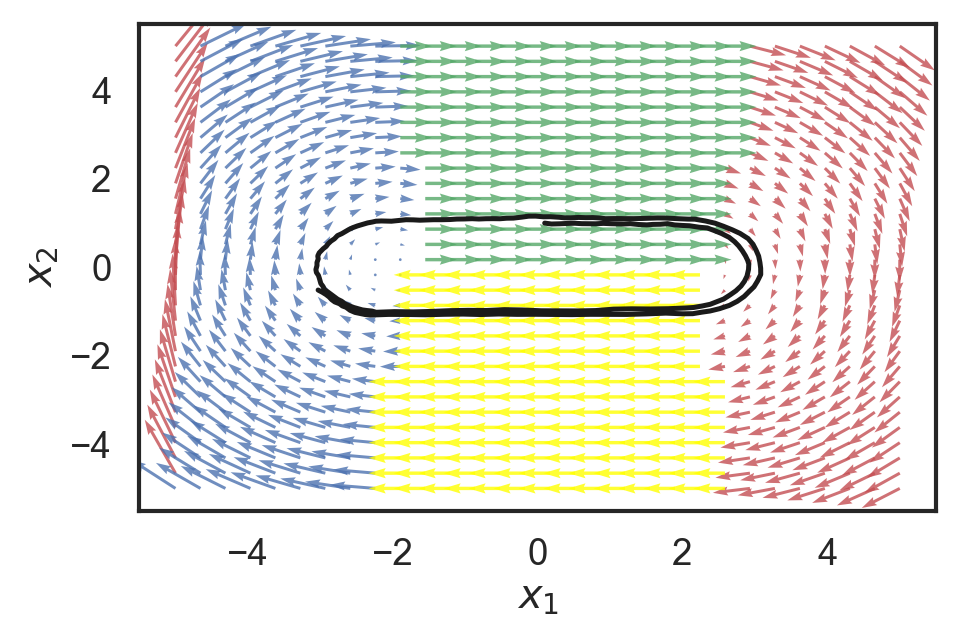

In [47]:
true_rslds, y1, x2, y2 = make_nascar_model(A1, A2, D_latent, D_obs, K, em_noise = noise, T=200, nTrls=2)
f, ax = plt.subplots(figsize=(6, 4))
ax = plot_most_likely_dynamics(true_rslds, xlim=(-5, 5), ylim=(-5, 5), nxpts=30, nypts=30, ax=ax)
for i in range(1): 
    ax.plot(x2[i][:, 0], x2[i][:, 1], 'k-')
plt.savefig("/Users/preeyakhanna/Dropbox/Carmena_Lab/Documentation/BMI_co_obs_paper/nascar_dynamics.svg")

In [84]:
### Generate model and sweep noise ### 
D_latent = 2; 
D_obs = 10; 
K = 4
A1 = random_rotation(D_latent, np.pi/24.)
A2 = random_rotation(D_latent, np.pi/48.)
nit = 10; 

dat = dict()
noises = [.0001, .01, .1, .2, .4, .8, 1.6, 3.2]

for i_n, noise in enumerate(noises): 

    true_rslds, y1, x2, y2 = make_nascar_model(A1, A2, D_latent, D_obs, K, em_noise = noise)

    ### Fit  model to y1 training data 
    nit = 20
    alpha = 0.01
    ver = 1; 
    mean_sub = False
    rslds, elbos = generate_models.fit_slds(y1, K, nit, alpha, ver=ver, mean_sub=mean_sub) 

    ### Test fit #### 
    r2_fit, r2_true = get_R2_fit_vs_true(rslds, true_rslds, x2, y2)
    
    dat[noise, 'fit'] = r2_fit 
    dat[noise, 'true'] = r2_true 
    

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Fit: 0.9901
True: 0.9991


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Fit: 0.8947
True: 0.9286


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Fit: 0.5247
True: 0.5471


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Fit: 0.3644
True: 0.3980


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Fit: 0.2024
True: 0.2463


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Fit: 0.0798
True: 0.1337


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Fit: 0.0221
True: 0.0592


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Fit: -0.0127
True: 0.0323


<IPython.core.display.Javascript object>


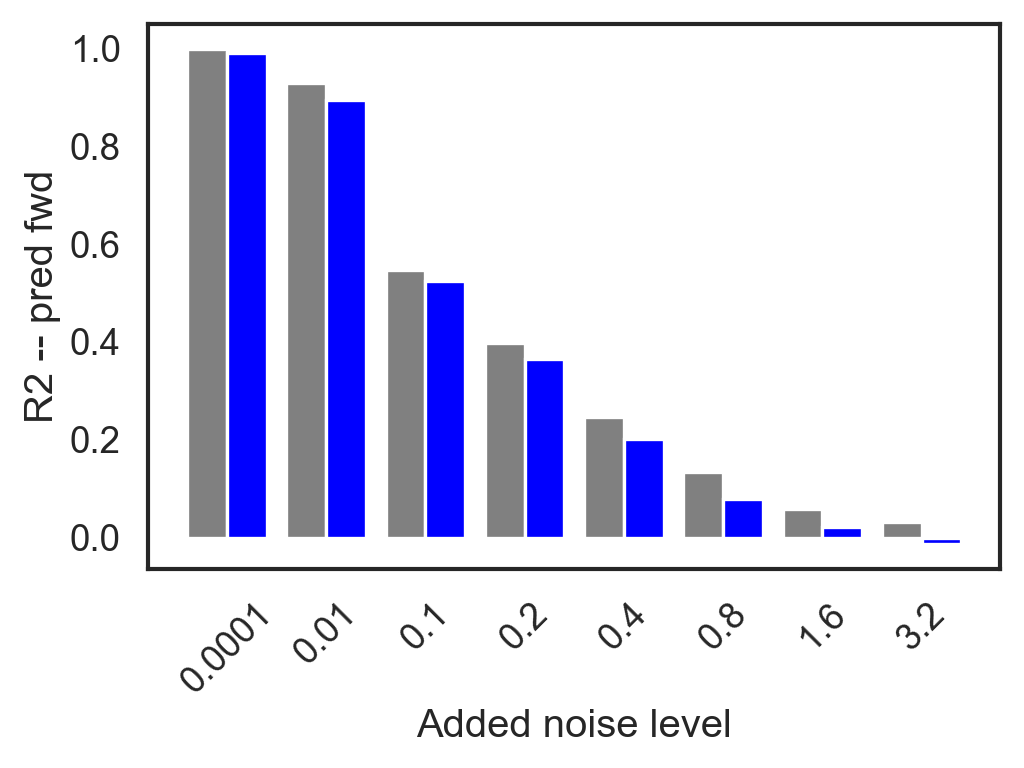

In [20]:
#pickle.dump(dat, open('/Users/preeyakhanna/bmi_dynamics_code/rslds_fit_vs_noise.pkl', 'wb'))
noises = [.0001, .01, .1, .2, .4, .8, 1.6, 3.2]

with open('/Users/preeyakhanna/bmi_dynamics_code/rslds_fit_vs_noise.pkl', 'rb') as f: 
    dat = pickle.load(f)

### Plot noise vs. R2 ###
f, ax = plt.subplots()
xlab = []; 
xtic = []; 

for i_n,noise in enumerate(noises): 
    
    ax.bar(i_n, dat[noise, 'true'], width=.4, color='gray')
    ax.bar(i_n+.4, dat[noise, 'fit'], width=.4, color='blue')
    
    xtic.append(i_n+.2)
    xlab.append(noise)

ax.set_xticks(xtic)
ax.set_xticklabels(xlab, rotation=45)
ax.set_xlabel('Added noise level')
ax.set_ylabel('R2 -- pred fwd')
#ax.set_title("Gray = generative model, Blue = model fit from training data")
plt.tight_layout()
f.savefig("/Users/preeyakhanna/Dropbox/Carmena_Lab/Documentation/BMI_co_obs_paper/nascar_noise_vs_r2.svg")

In [13]:
### Generate noisy model and sweep fit ####
D_latent = 2; 
D_obs = 10; 
noise = 0.1
true_K = 4; 

dat2 = dict()

Y1 = []; 
Y2 = []; 

for i in range(10):
    A11 = random_rotation(D_latent, np.pi/24.)
    A21 = random_rotation(D_latent, np.pi/48.)

    true_rslds, y1, x2, y2 = make_nascar_model(A11, A21, D_latent, D_obs, true_K, em_noise = noise)
    Y1.append(y1)
    Y2.append(y2)
    nit = 20
    alpha = 0.01
    ver = 1; 
    mean_sub = False

    for i_k, K in enumerate([4]): 

        ### Fit  model to y1 training data 
        rslds, elbos = generate_models.fit_slds(y1, K, nit, alpha, ver=ver, mean_sub=mean_sub) 

        ### Test fit #### 
        r2_fit, r2_true = get_R2_fit_vs_true(rslds, true_rslds, x2, y2)
        dat2[K, i, 'fit'] = r2_fit
        dat2[K, i, 'true'] = r2_true; 
        dat2[K, i, 'elbo'] = elbos

pickle.dump(dat, open('/Users/preeyakhanna/bmi_dynamics_code/rslds_fit_vs_K_eq_4_noise_0.1_ver1.pkl', 'wb'))


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Fit: 0.5380
True: 0.5553


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Fit: 0.5452
True: 0.5672


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Fit: 0.4999
True: 0.5400


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Fit: 0.5500
True: 0.5685


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Fit: 0.5116
True: 0.5395


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Fit: 0.5413
True: 0.5722


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Fit: 0.5501
True: 0.5822


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Fit: 0.5568
True: 0.5814


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Fit: 0.5368
True: 0.5680


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Fit: 0.5146
True: 0.5685


In [ ]:
### Plot noise vs. R2 ###
# f, ax = plt.subplots(ncols = 2, figsize=(10, 4))
# xlab = []; 
# xtic = []; 

# ### Print alpha ### 
# alpha = sweep_alpha(y1)
# max_ = -1000; 
# dt = []; 

# ### Plot Ridge ### 
# for i_a, (alph, val) in enumerate(alpha.items()): 
#     dt.append([alph, val])
    
# dt = np.vstack((dt))
# ix_max = np.argmax(dt[:, 1])
# alpha_max = dt[ix_max, 0]
# r2_ridge = fit_ridge(alpha_max, y1, y2)
# ax[0].bar(-1, r2_ridge, color='gray')
# ax[0].bar(-1, 0, color='gray')
# xlab.append('Ridge')
# xtic.append(-1)

# ### Sweep through K ### 
# for i_k, K in enumerate([1, 2, 3, 4, 5, 6, 7]): 
#     x_fit = []; 
#     x_elbo = []; 
    
#     for i in range(10): 
#         x_fit.append(dat2[K, i, 'fit'])
#         x_elbo.append(dat2[K, i, 'elbo'][-1])
    
#     ax[0].bar(i_k, np.mean(x_fit), color='blue')
#     ax[0].errorbar(i_k, np.mean(x_fit), np.std(x_fit), color='k', marker='|')
    
#     ax[1].bar(i_k, np.mean(x_elbo), color='blue')
#     ax[1].errorbar(i_k, np.mean(x_elbo), np.std(x_elbo), color='k', marker='|')
    
#     xtic.append(i_k)
#     xlab.append('SLDS, K=%d'%K)

# for axi in ax: 
#     axi.set_xticks(xtic)
#     axi.set_xticklabels(xlab, rotation=45, fontsize=8)
#     axi.set_xlabel('Model and SLDS # discrete dimensions fit')
# ax[0].set_ylabel('R2 -- pred fwd')
# ax[1].set_ylabel('ELBO')
# #ax[0].set_ylim([.78, .97])
# #ax[1].set_ylim([7900, 8500])
# plt.tight_layout()

In [14]:
%matplotlib notebook

In [ ]:
# K = 4; 
# true_rslds, y1, x2, y2 = make_nascar_model(A1, A2, D_latent, D_obs, K, em_noise = noise)
# plot_most_likely_dynamics(true_rslds)

In [150]:
pdb

Automatic pdb calling has been turned ON


<IPython.core.display.Javascript object>


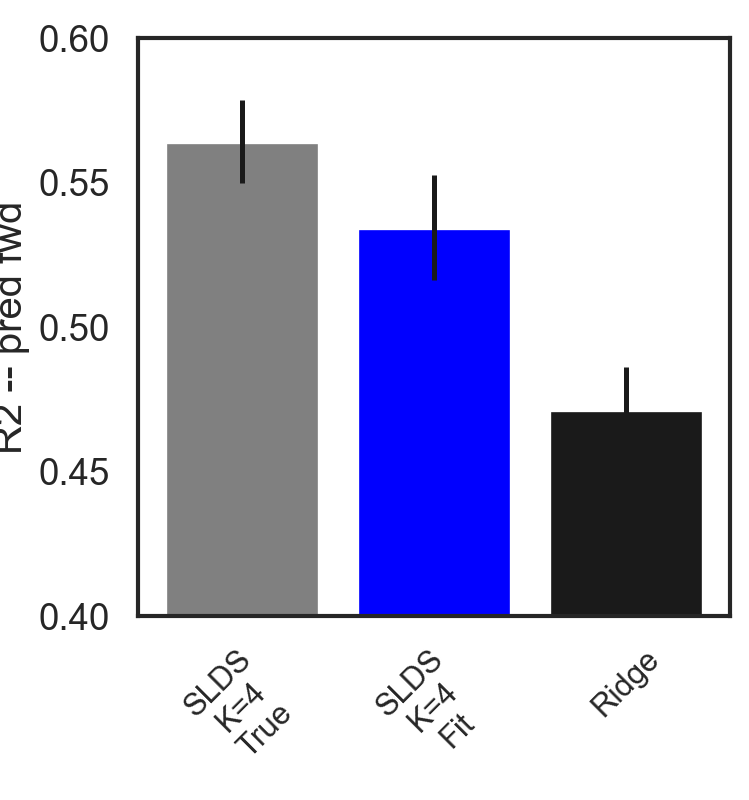

In [25]:
#### SIMPLE plot RIDGE // K== 4 (train, test) ######
with open('/Users/preeyakhanna/bmi_dynamics_code/rslds_fit_vs_K_eq_4_noise_0.1_ver1.pkl', 'rb') as f: 
    dat = pickle.load(f)
f, ax = plt.subplots()
xlab = []; 
xtic = []; 

### Print alpha ### 
alpha = sweep_alpha(Y1[0])
dt = []; 

### Plot Ridge ### 
for i_a, (alph, val) in enumerate(alpha.items()): 
    dt.append([alph, val])
    
dt = np.vstack((dt))
ix_max = np.argmax(dt[:, 1])
alpha_max = dt[ix_max, 0]

r2_ridge = []
for i in range(10): 
    r2_ridge.append(fit_ridge(alpha_max, Y1[i], Y2[i]))

### Ridge bar plot ###
ax.bar(2, np.mean(r2_ridge), color='k')
ax.errorbar(2, np.mean(r2_ridge), np.std(r2_ridge), color='k', marker='|')

### Sweep through K ### 
K = 4; 
x_fit = []; 
x_tru = []; 
for i in range(10): 
    x_fit.append(dat2[K, i, 'fit'])
    x_tru.append(dat2[K, i, 'true'])
    
ax.bar(0, np.mean(x_tru), color='gray')
ax.errorbar(0, np.mean(x_tru), np.std(x_tru), color='k', marker='|')

ax.bar(1, np.mean(x_fit), color='blue')
ax.errorbar(1, np.mean(x_fit), np.std(x_fit), color='k', marker='|')


xlab.append('SLDS\nK=%d\nTrue'%K)
xlab.append('SLDS\nK=%d\nFit'%K)
xlab.append('Ridge')

ax.set_xticks(np.arange(3))
ax.set_xticklabels(xlab, rotation=45, fontsize=14)
ax.set_ylabel('R2 -- pred fwd')
ax.set_ylim([.4, .6])
plt.tight_layout()
f.savefig("/Users/preeyakhanna/Dropbox/Carmena_Lab/Documentation/BMI_co_obs_paper/models_vs_r2.svg")